In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display

import tensorflow as tf
print(tf. __version__)

from scipy.io import loadmat
from scipy import linalg
from scipy.special import lambertw as lambertw
import numba as nb

2.10.0


In [2]:
from SQ_NN import SQ_NN, SQ_NN_tf, Decoder_aug

In [3]:
# Training set
parameters_zscore = 0
sq_min = np.exp(-5) # minimum of sq

if 0:
    X_file = './training_set/input_grid_all_GPR80.csv'
    Y_file = './training_set/target_grid_all.csv'
else:
    X_file = './training_set/input_random_all_GPR80.csv'
    Y_file = './training_set/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

eta_mean = np.mean(eta)
eta_std = np.std(eta)
kappa_mean = np.mean(kappa)
kappa_std = np.std(kappa)
A_mean = np.mean(A)
A_std = np.std(A)

# normalization
eta_z = (eta-eta_mean)/eta_std
kappa_z = (kappa-kappa_mean)/kappa_std
A_z = (A-A_mean)/A_std

if parameters_zscore:
    parameters_train = np.array([eta_z,kappa_z,A_z]).T
else:
    parameters_train = np.array([eta,kappa,A]).T

sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

# rescale
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

print('eta ~ N({:0.4f},{:0.4f})'.format(np.mean(eta),np.var(eta)))
print('kappa ~ N({:0.4f},{:0.4f})'.format(np.mean(kappa),np.var(kappa)))
print('A ~ N({:0.4f},{:0.4f})'.format(np.mean(A),np.var(A)))

eta ~ N(0.2301,0.0157)
kappa ~ N(0.2595,0.0193)
A ~ N(12.9685,48.1309)


In [4]:
# from scipy.io import loadmat
# filename_EQSANS = './EQSANS.mat'
# loaded_EQSANS = loadmat(filename_EQSANS)
# q_EQSANS_0 = loaded_EQSANS['Q_real'][:,0]#.astype('float32')
# qsig_EQSANS = loaded_EQSANS['qsig'][:,0]#.astype('float32')
# data = loaded_EQSANS['data']#.astype('float32')
# qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
# q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
# qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)

data_EQSANS = np.loadtxt('./EQSANS.txt',delimiter=',',skiprows=2)
q_EQSANS_0 = data_EQSANS[:,0]#.astype('float32')
qsig_EQSANS = data_EQSANS[:,3]#.astype('float32')
IQ_EQSANS = data_EQSANS[:,1]#.astype('float32')
E_EQSANS = data_EQSANS[:,2]#.astype('float32')

qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)

In [5]:
def hardsphere(q,sigma=1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2
    return P

def scale(q,x,scale):
    qs = q*scale
    f_interp = interp.interp1d(qs, x, fill_value='extrapolate')
    x_interp = f_interp(q)
    return x_interp

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''
    
    Qmean = Q
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        w_gauss = (1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ_resoln = IQ_th*w_gauss
        
        IQ.append(np.trapz(IQ_resoln,Q_fine)/np.trapz(w_gauss,Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out

def SQ_th(sq_func,fp):
    # structure factor
    return sq_func(fp[0:3])

def IQ_th(sq_func,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = SQ_th(sq_func,fp)

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)
    
    IQ_res_scale_interp = f_interp(q_rs)
    return IQ_res_scale_interp



In [6]:
def IQ_exp(sq_GT,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = sq_GT

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)

    IQ_exp = f_interp(q_rs)
    return IQ_exp

In [7]:
data = loadmat('IQ_SVD_rand.mat')
IQ_exp_list = data['IQ_exp_list']
sq_GT_list = data['sq_GT_list']
fp_GT_list = data['fp_GT_list']

In [8]:
def SQ_HS(QDHS,phi):
    Alpha = (1+2*phi)**2/(1-phi)**4
    Beta = -6*phi*(1+phi/2)**2/(1-phi)**4
    Gamma = phi*Alpha/2
    G = lambda x: Alpha*(np.sin(x)-x*np.cos(x))/x**2 + Beta*(2*x*np.sin(x)+(2-x**2)*np.cos(x)-2)/x**3 + Gamma*(-x**4*np.cos(x)+4*((3*x**2-6)*np.cos(x)+(x**3-6*x)*np.sin(x)+6))/x**5
    S_HS = 1/(1+24*phi*G(2*QDHS/2)/(2*QDHS/2))
    return S_HS

phi_list = (np.arange(100+1))/100*0.5
IQ_HS_list = np.array([IQ_exp(SQ_HS(q,phi),fp=[0,0,0,1,1,0.01]) for phi in phi_list])

## ACF

In [9]:
F = IQ_exp_list - np.mean(IQ_exp_list,axis=0) # N by 80

In [10]:
dr = 0.04
n_bins = 80
rr = (np.arange(n_bins))*dr
n_particle = len(F)

@nb.jit
def c_r(weight):
    sigma = 1e-12
    c = np.zeros(n_bins)
    g = np.zeros(n_bins) + np.ones(n_bins)*sigma
    weight_mean = (np.sum(weight)/n_particle)
    for j in range(n_particle):
        for k in range(n_particle):
            d_jk = np.sqrt(np.sum((F[j]-F[k])**2))
            i_d_jk = np.floor(d_jk/dr)
            if i_d_jk<n_bins:
                c[int(i_d_jk)] += weight[j]*weight[k]/weight_mean**2
                g[int(i_d_jk)] += 1
    return c/g-1

@nb.jit
def c_r_center(weight):
    c = np.zeros(n_bins)
    v = np.zeros(n_bins)
#     g = np.zeros(n_bins)
    weight_mean = np.mean(weight)
    weight_center = weight - weight_mean
#     weight_z = weight_center/np.std(weight)
    for j in range(n_particle):
        for k in range(n_particle):
            d_jk = np.sqrt(np.sum((F[j]-F[k])**2))
            i_d_jk = np.floor(d_jk/dr)
            if i_d_jk<n_bins:
                c[int(i_d_jk)] += weight_center[j]*weight_center[k]
                v[int(i_d_jk)] += weight_center[j]*weight_center[j]
#                 g[int(i_d_jk)] += 1
    c[0]=1
    v[0]=1
    return c/v

In [11]:
c_r_eta = c_r_center(eta)
c_r_kappa = c_r_center(kappa)
c_r_A = c_r_center(A)

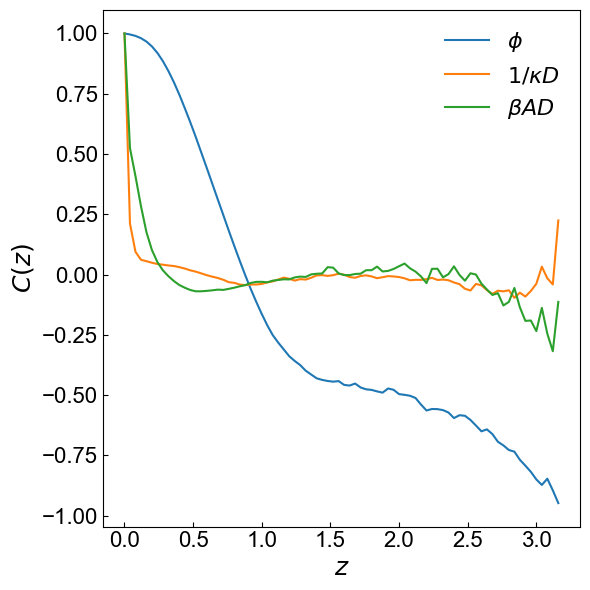

In [12]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.plot(rr,c_r_eta,label=r'$\phi$')
ax.plot(rr,c_r_kappa,label=r'$1/\kappa D$')
ax.plot(rr,c_r_A,label=r'$\beta AD$')

ax.set_xlabel(r'$QD$',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=16,framealpha=0)

ax.set_xlabel(r'$z$',fontsize=18)
ax.set_ylabel(r'$C(z)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.tight_layout()
plt.show()